In [ ]:
# !pip install -q swig
# !pip install -q gymnasium[box2d]

# Lunar Lander

https://gymnasium.farama.org/environments/box2d/lunar_lander/

1. **Objective**: The main objective is to land the lunar module between two flags safely. Landing outside the flags or crashing the module results in reduced rewards or penalties.

2. **States**: The state (or observation) space has eight dimensions:
   - X and Y coordinates.
   - X and Y velocity.
   - Angle and angular velocity.
   - A boolean (0 or 1) for whether the left leg has made contact.
   - A boolean (0 or 1) for whether the right leg has made contact.

3. **Actions**: The agent can take one of four actions at each time step:
   - Do nothing.
   - Fire the main engine (to slow descent).
   - Fire the left orientation engine (to push the lander to the right).
   - Fire the right orientation engine (to push the lander to the left).

4. **Rewards**: 
   - For each frame that the lander is flying, it gets a reward between -0.3 to -0.03 points.
   - If the lander crashes (e.g., comes in too fast or lands at a bad angle), it gets a penalty of -100 points.
   - If the lander lands successfully and safely, it receives +100 points.
   - There are additional points for moving closer to the center and penalties for using fuel (firing engines).

5. **Versions**:
   - **LunarLander-v2**: This is the standard version.
   - **LunarLanderContinuous-v2**: In this version, instead of discrete actions, the agent has to choose two continuous actions. The first one determines the main engine's thrust (0 not firing, 1 full throttle), and the second one controls orientation (-1 full left, 0 off, 1 full right).


## Policy gradient using NN

Worked reasonably well / quickly on CartPole.

In [40]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [41]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

state_size = env.observation_space.shape[0]
n_actions = env.action_space.n

state_size, n_actions

(8, 4)

In [48]:
# Hyperparameters
LEARNING_RATE = 0.01
EPISODES = 100

In [49]:
inputs = keras.Input(shape=(state_size,))
x = Dense(24, activation='relu')(inputs)
x = Dense(24, activation='relu')(x)
outputs = Dense(n_actions, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=LEARNING_RATE)

In [50]:
episode_scores = []
for episode in range(1, EPISODES + 1):
    state, _ = env.reset()
    terminated = False
    truncated = False
    episode_states, episode_actions, episode_rewards = [], [], []

    while not terminated and not truncated:
        # Forward pass
        action_prob = model.predict(state.reshape(1, -1), verbose=0)[0]
        action = np.random.choice(n_actions, p=action_prob)

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Store state, action and reward
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)

        state = next_state

    episode_scores.append(np.sum(episode_rewards))

    # Compute discounted rewards
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(episode_rewards):
        cumulative_reward = reward + 0.99 * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    discounted_rewards = np.array(discounted_rewards)
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)

    # Compute loss values and perform a gradient step
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        probs = model(np.vstack(episode_states))
        indices = tf.range(0, tf.shape(probs)[0]) * tf.shape(probs)[1] + episode_actions
        chosen_probs = tf.gather(tf.reshape(probs, [-1]), indices)
        loss = -tf.reduce_mean(tf.math.log(chosen_probs) * discounted_rewards)

    # Compute gradients and update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f"Episode: {episode}, Total Reward: {np.sum(episode_rewards)}")

env.close()


Episode: 1, Total Reward: -205.1117515634882
Episode: 2, Total Reward: -468.43117238442613
Episode: 3, Total Reward: -145.15947189973565
Episode: 4, Total Reward: -40.20466684828681
Episode: 5, Total Reward: -125.17779519179562
Episode: 6, Total Reward: -204.26388678142445
Episode: 7, Total Reward: -343.6726308305831
Episode: 8, Total Reward: -124.68142859361437
Episode: 9, Total Reward: -317.840540113148
Episode: 10, Total Reward: -247.3970314310432
Episode: 11, Total Reward: -35.715982251507285
Episode: 12, Total Reward: -337.64201675132097
Episode: 13, Total Reward: -68.79790535611585
Episode: 14, Total Reward: -385.29652367177135
Episode: 15, Total Reward: -265.52137904431925
Episode: 16, Total Reward: -517.8472051797982
Episode: 17, Total Reward: -499.40414001051977
Episode: 18, Total Reward: -345.7774676658896
Episode: 19, Total Reward: -271.76583811256864
Episode: 20, Total Reward: -410.1447685898419
Episode: 21, Total Reward: -524.5942789496575
Episode: 22, Total Reward: -278.3

In [53]:
mean_score = sum(episode_scores) / len(episode_scores)
mean_score

-226.4657665893529

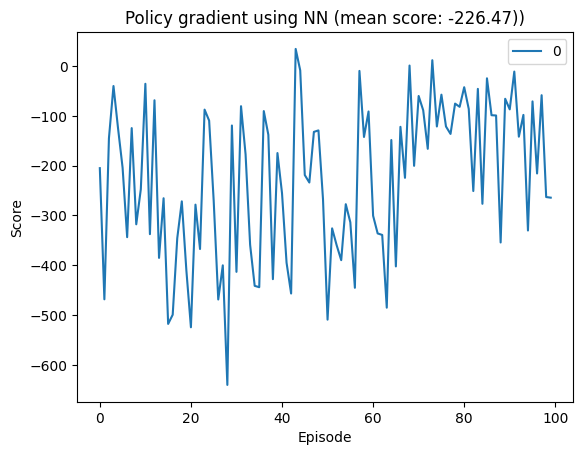

In [54]:
plot_data = pd.DataFrame(episode_scores, columns=['episode_score'])
sns.lineplot(plot_data.values) 
plt.title(f'Policy gradient using NN (mean score: {mean_score:.2f}))')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

# Run the trained model

In [55]:
env = gym.make("LunarLander-v2", render_mode="human")
state, _ = env.reset()
state = np.reshape(state, [1, 8])

terminated = False
truncated = False

while not terminated and not truncated:
    env.render()

    action_prob = model.predict(state)
    action = np.argmax(action_prob[0])

    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = np.reshape(next_state, [1, 8])
    state = next_state

    # Adding a small sleep to make the rendering smoother
    time.sleep(0.01)

# Close the environment
env.close()

1/1 [==============================] - 0s 22ms/step


KeyboardInterrupt: 